# Outline

- Installing and using Nibabel Python Library

- Data pre-processing

- Segmenting images with the Gaussian mixture model


## Using Nibabel

https://nipy.org/nibabel/

```conda install -c conda-forge nibabel```

In [30]:
from numpy import zeros, concatenate
import nibabel as nib

### Loading data

In [31]:
img_nibabel = nib.load("T1_mask.nii")

type(img_nibabel)

nibabel.nifti1.Nifti1Image

In [32]:
hdr = img_nibabel.header
print(hdr)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 128 128  70   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.   2.   2.   2.2  0.   0.   0.   0. ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'5.0.11'
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 1.0
quatern_d       : 0.0
qoffset_x       : 125.5061
qoffset_y       : -109.38977
qoffset_z       : -86.742615
srow_x      

In [33]:
print(hdr.get_xyzt_units())

('mm', 'sec')


### Load image into numpy array

In [34]:
img1 = img_nibabel.get_fdata()
type(img1)

numpy.memmap

In [35]:
img1.shape

(128, 128, 70)

In [36]:
img_nibabel = nib.load("b0_mask.nii")
img2 = img_nibabel.get_fdata()

In [37]:
img2.shape

(128, 128, 70)

### Plot images

In [38]:
from matplotlib.pyplot import subplots, tight_layout

In [39]:
img_slice = 42

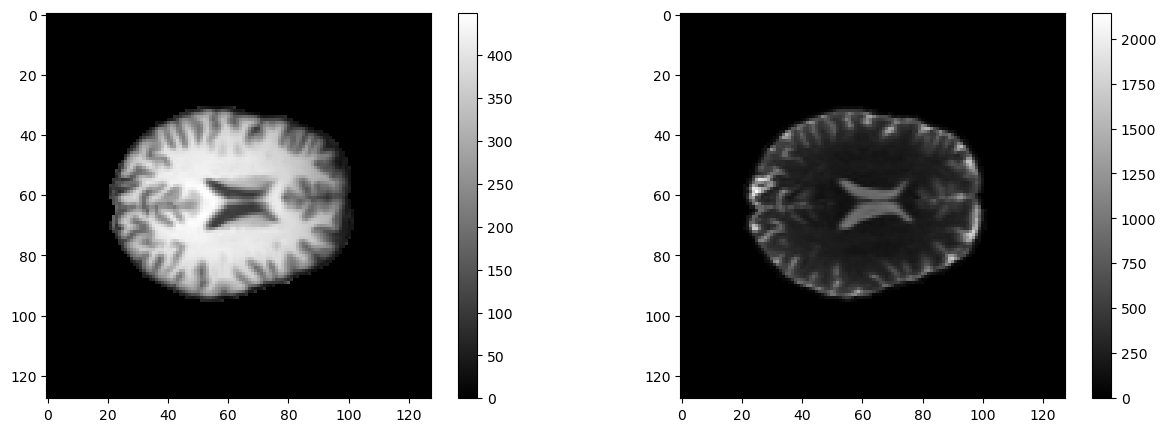

In [40]:
fig, ax = subplots(nrows=1, ncols=2, figsize=(15, 5))
f1 = ax[0].imshow(img1[:, :, img_slice], cmap="gray")
f2 = ax[1].imshow(img2[:, :, img_slice], cmap="gray")

fig.colorbar(f1, ax=ax[0])
fig.colorbar(f2, ax=ax[1]);

## Pre-processing

In [41]:
img1_slice = img1[:, :, img_slice]
img2_slice = img2[:, :, img_slice]

### Mask image

In [13]:
mask = (img1_slice>0) & (img2_slice>0) 

In [42]:
img1_nz = img1_slice[mask]
img2_nz = img2_slice[mask]

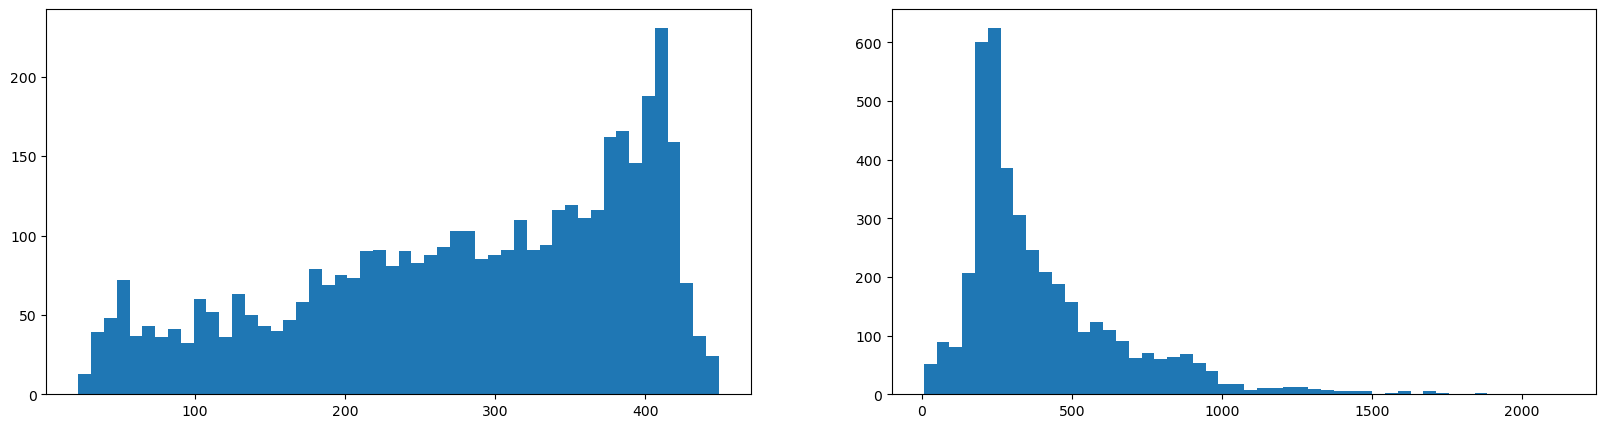

In [43]:
fig, ax = subplots(nrows=1, ncols=2, figsize=(20, 5))

ax[0].hist(img1_nz, bins=50)
ax[1].hist(img2_nz, bins=50);

### Scale the image

In [44]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

img1_scaled = scaler.fit_transform(img1_nz.reshape(-1, 1))
img2_scaled = scaler.fit_transform(img2_nz.reshape(-1, 1))

### Concatenate to samples-features array

In [45]:
all_img_scaled = concatenate([img1_scaled, img2_scaled], axis=1)

all_img_scaled.shape

(4132, 2)

## GMM clustering

### Visualise the feature space

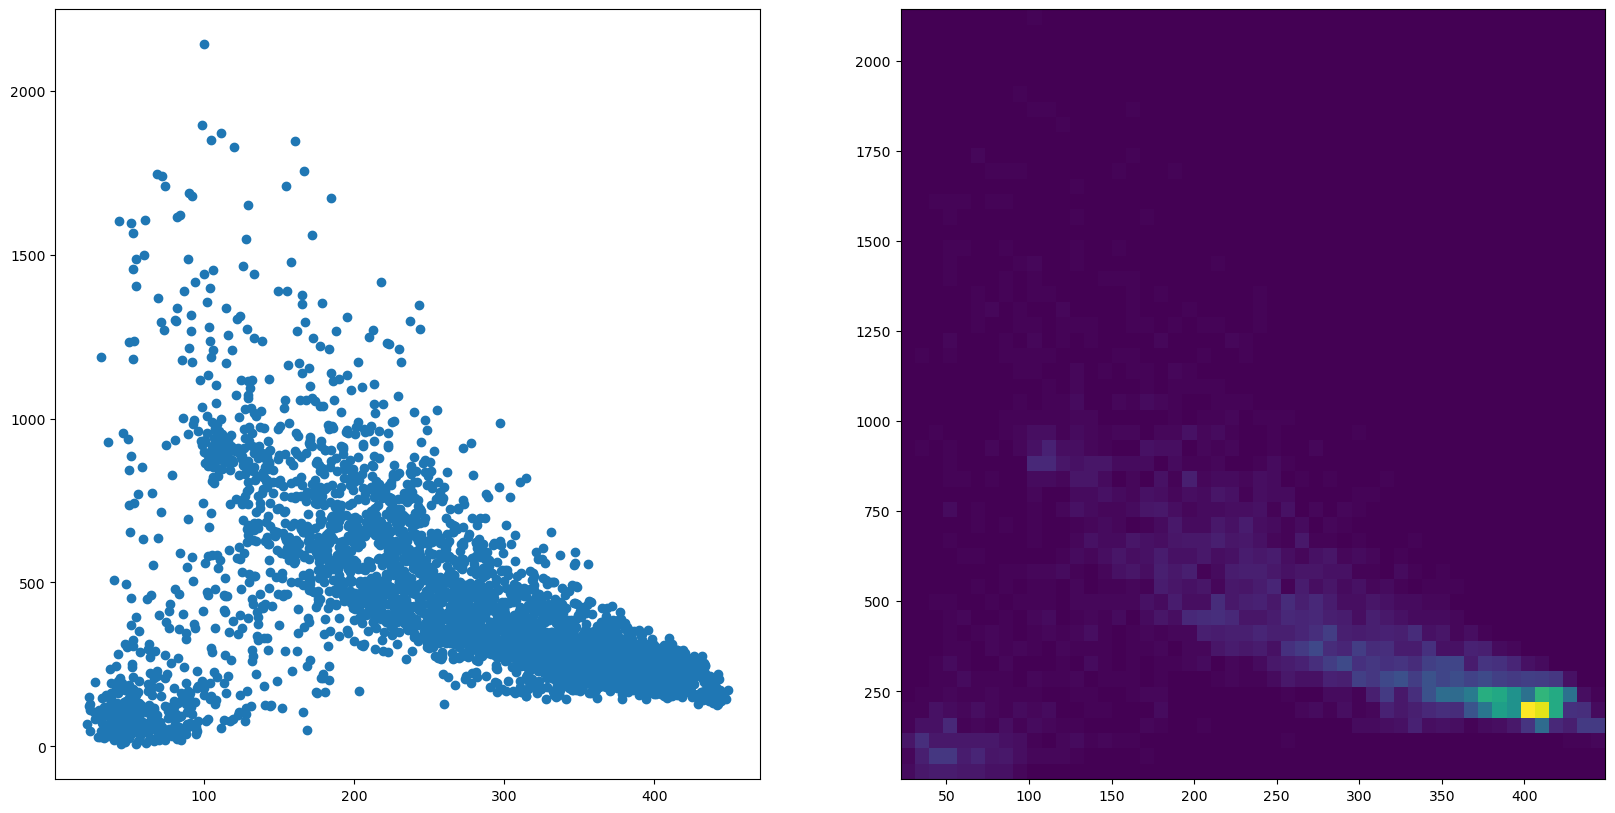

In [46]:
fig, ax = subplots(1, 2, figsize=(20, 10))

ax[0].scatter(img1_nz, img2_nz)
ax[1].hist2d(img1_nz, img2_nz, bins=50);

### Fit GMM model

In [47]:
from sklearn.mixture import GaussianMixture

In [56]:
RANDOM_SEED = 123

no_clusters = 3

gmm = GaussianMixture(no_clusters, random_state=RANDOM_SEED)

all_img_labels = gmm.fit_predict(all_img_scaled)
all_img_labels += 1

Text(0, 0.5, 'Image 2')

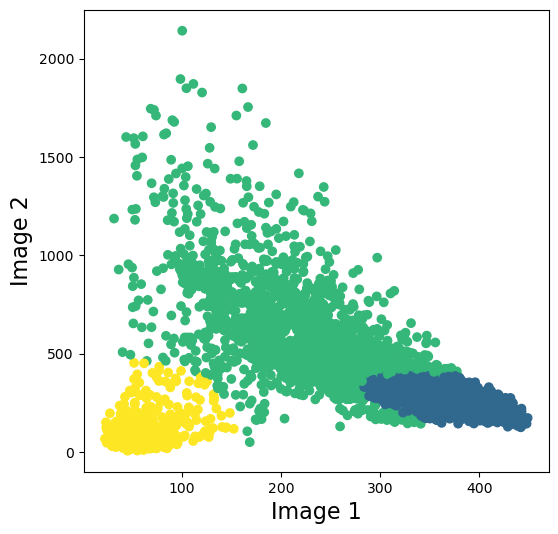

In [57]:
fig, ax = subplots(1, 1, figsize=(6, 6))

ax.scatter(img1_nz, img2_nz, c=all_img_labels, cmap='viridis', vmin=0)
ax.set_xlabel('Image 1', fontsize=16)
ax.set_ylabel('Image 2', fontsize=16)

In [59]:
all_img_labels_mapped = zeros(img1_slice.shape)
all_img_labels_mapped[mask] = all_img_labels

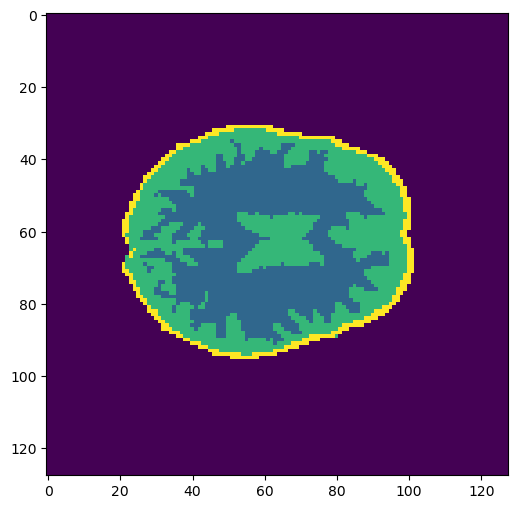

In [60]:
fig, ax = subplots(1, 1, figsize=(6, 6))
ax.imshow(all_img_labels_mapped[:, :], cmap='viridis');